In [1]:
import data_preparation
import custom_func
import model, model_w
import model_analysis

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
%matplotlib inline

# Sensitivity Max Distance travelled

In [ ]:
potential_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
# Import data
spill_data = pd.read_excel('Inputs/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()

current_input_param = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current input param', header=0).copy()

input_parameters = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

## Data Extraction

In [ ]:
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(potential_st_coord)

coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
spill_coord.columns = ['St_Latitude', 'St_Longitude']
display(spill_coord)

In [ ]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

## Emphasize sensitivity

In [ ]:
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 1000*0.25, 0.25, 10**-4*0.25, 10**-2*0.25, 10 * 0.25]
#W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

QuantityMin = 2
# NumberStMax_m4b = 5
current_vs_proposed = 'proposed'

In [ ]:
DistanceMaxL = [5, 7, 8, 10, 11, 12, 15, 20]
NumberStMaxL = [2, 5, 8, 10, 12]
select_1sL =[]
coverage_percentageL =[]
MeanResponseTimeL =[]
max_distance_sensitivity_L = []

In [ ]:
# Model
for i in range(len(DistanceMaxL)):
    for j in range(len(NumberStMaxL)):
        model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
            spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
            = model_w.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
                  Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[j], Distance, Distance_n,
                  W, QuantityMin, DistanceMaxL[i], Cf_s, CostU, Budget,
                  BigM, MaxFO)
        select_1sL.append(select_1s_m4b.index)
        coverage_percentageL.append(coverage_percentage_m4b)
        MeanResponseTimeL.append(MeanResponseTime_m4b)
        max_distance_sensitivity_L.append([DistanceMaxL[i], NumberStMaxL[j], MeanResponseTime_m4b])

In [ ]:

model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
    spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
    = model_w.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[1], Distance, Distance_n,
          W, QuantityMin, DistanceMaxL[0], Cf_s, CostU, Budget,
          BigM, MaxFO)
select_1sL.append(select_1s_m4b.index)
coverage_percentageL.append(coverage_percentage_m4b)
MeanResponseTimeL.append(MeanResponseTime_m4b)
max_distance_sensitivity_L.append([DistanceMaxL[0], NumberStMaxL[1], MeanResponseTime_m4b])

# Draw the network
assignment_line_m4b = model_analysis.draw_network_diagram(DistanceMaxL[0], NumberStMaxL[1], Sensitivity_R, spill_df_m4b, station_df_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b, deploy_1s_m4b, select_1s_m4b, current_vs_proposed)

In [ ]:
# max_distance_sensitivity_L

In [ ]:
max_distance_sensitivity_df = pd.DataFrame(max_distance_sensitivity_L,
                                              columns=['Max Distance Travelled','Max Number of Station','Mean Response Time'])
max_distance_sensitivity_df

In [ ]:
sns.lineplot(data = max_distance_sensitivity_df, x='Max Distance Travelled', y='Mean Response Time', hue='Max Number of Station')

In [ ]:
a = 2
a

## Emphasize distance metric

In [ ]:

BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [100*0.25, 0.25, 100*0.25, 10**-4*0.25, 10**-2*0.25, 10 * 0.25]
# we should emphasize spill size as well when trying to min distance. otherwise, it will minimize distance, & just assign nothing
# dropping 100 from sensitivity weight & add in distance min 100*
QuantityMin = 2
# NumberStMax_m4b = 5
current_vs_proposed = 'proposed'
current_vs_proposed

In [ ]:
DistanceMaxL = [5, 7, 8, 10, 11, 12, 15, 20]
NumberStMaxL = [5, 8, 10, 12]
select_1sL =[]
coverage_percentageL =[]
MeanResponseTimeL =[]
max_distance_sensitivity_L = []

pareto_front_max_obj = []
pareto_front_min_obj = []


In [ ]:
# Model
for i in range(len(DistanceMaxL)):
    for j in range(len(NumberStMaxL)):
        model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
            spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
            = model_w.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
                  Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[j], Distance, Distance_n,
                  W, QuantityMin, DistanceMaxL[i], Cf_s, CostU, Budget,
                  BigM, MaxFO)
        select_1sL.append(select_1s_m4b.index)
        coverage_percentageL.append(coverage_percentage_m4b)
        MeanResponseTimeL.append(MeanResponseTime_m4b)
        max_distance_sensitivity_L.append([DistanceMaxL[i], NumberStMaxL[j], MeanResponseTime_m4b])

        assignment_line_m4b = model_analysis.draw_network_diagram(DistanceMaxL[i], NumberStMaxL[j], Sensitivity_R, spill_df_m4b, station_df_m4b, MeanResponseTime_m4b,      coverage_percentage_m4b, assignment_m4b, deploy_1s_m4b, select_1s_m4b, current_vs_proposed)

In [ ]:
#len(assignment)

In [ ]:
max_distance_sensitivity_df = pd.DataFrame(max_distance_sensitivity_L,
                                              columns=['Max Distance Travelled','Max Number of Station','Mean Response Time'])
max_distance_sensitivity_df

In [ ]:
sns.lineplot(data = max_distance_sensitivity_df, x='Max Distance Travelled', y='Mean Response Time', hue='Max Number of Station')

# Sensitivity: weight vector

In [ ]:
## Emphasi

In [ ]:

BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [100*0.25, 0.25, 100*0.25, 10**-4*0.25, 10**-2*0.25, 10 * 0.25]
# we should emphasize spill size as well when trying to min distance. otherwise, it will minimize distance, & just assign nothing
# dropping 100 from sensitivity weight & add in distance min 100*
QuantityMin = 2
# NumberStMax_m4b = 5
current_vs_proposed = 'proposed'

DistanceMax = 10
NumberStMax = 5

In [ ]:
# W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
# w1 = [.25, .5, .75]; w2 = [.25, .5, .75]; w3 = [.25, .5, .75];
w1 = [.25, 10, 100]; w2 = [10**-2, .25, 10, 100, 10**4]; w3 = [10**-2, .25, 1, 10, 100]
w4 = [.25, .75]; w5 = .25; w6 = .25; w7 = .25; w8 = .25

weight_sensi_L = []
MeanResponseTime_m4bL=[]
coverage_percentage_m4bL=[]
objValues_m4bL = []

In [ ]:
#import model

## Run Model 4(b)

In [ ]:
# Model
for i in range(len(w1)):
    for j in range(len(w2)):
        for k in range(len(w3)):
            for n in range(len(w4)):
                W = [w1[i], w2[j], w3[k], w4[n], w5, w6, w7, w8]
                model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
                    spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
                    = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
                          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax, Distance, Distance_n,
                          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
                          BigM, MaxFO)

                #coverage_percentage_m4bL.append(coverage_percentage_m4b)
                #MeanResponseTime_m4bL.append(MeanResponseTime_m4b)
                #objValues_m4bL.append(objValues_m4b[1::2][1]) # negative value of cost for [0] starting guess issue i think
                weight_sensi_L.append([w1[i], w2[j], w3[k], w4[n], w5, w6, w7, w8,
                                       coverage_percentage_m4b, MeanResponseTime_m4b, objValues_m4b[1::2][1]]) # coverage of sensitive area ++

In [ ]:
weight_sensi_L


In [ ]:
data_weight_pcp = pd.DataFrame(weight_sensi_L)
data_weight_pcp.columns = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'coverage_percentage', 'MeanResponseTime', 'objValues2']
data_weight_pcp

In [ ]:
data_weight_pcp.info()

In [ ]:
data_weight_pcp1 = data_weight_pcp[['w1', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'coverage_percentage']].copy()
data_weight_pcp2 = data_weight_pcp[['w1', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'MeanResponseTime']].copy()
data_weight_pcp3 = data_weight_pcp[['w1',  'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'objValues2']].copy()

## PCP

In [2]:
data_weight_pcp = pd.read_excel('Outputs/data_weight_pcp.xlsx')
data_co_sorted = data_weight_pcp.sort_values(['coverage_percentage'], ascending=False)
data_MeanRT_sorted = data_weight_pcp.sort_values(['MeanResponseTime'], ascending=False)
data_cost_sorted = data_weight_pcp.sort_values(['objValues2'], ascending=False)

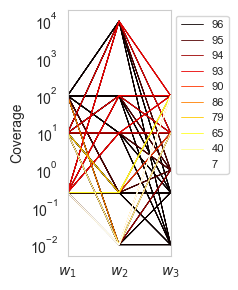

In [3]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(2,3))
kwargs = {'lw':0.6} #'alpha':1,
ax = pd.plotting.parallel_coordinates(data_co_sorted, class_column='coverage_percentage',
                                 cols=['w1','w2', 'w3'],
                                 colormap=plt.get_cmap('hot'),
                                axvlines=False,
                                 **kwargs                      )
plt.yscale("log")
plt.ylabel('Coverage', fontsize=10)
plt.yticks(fontsize=10)
ax.set_xticklabels(['$w_1$', '$w_2$', '$w_3$'])
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,1), fontsize = 8)
ax.grid(False)
fig.savefig(f'Outputs/Fig8a PCP.png', transparent=False, dpi=400, bbox_inches = "tight")

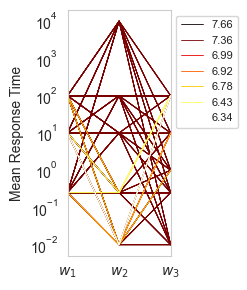

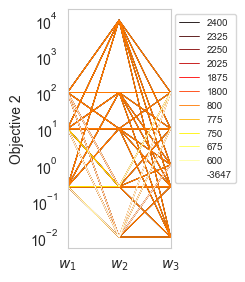

In [4]:
fig, ax = plt.subplots(figsize=(2,3))
kwargs = {'lw':0.6} #'alpha':1,
ax = pd.plotting.parallel_coordinates(data_MeanRT_sorted, class_column='MeanResponseTime',
                                 cols=['w1','w2', 'w3'],
                                 colormap=plt.get_cmap('hot'),axvlines=False,
                                 **kwargs                      )
plt.yscale("log")
plt.ylabel('Mean Response Time', fontsize=10)
plt.yticks(fontsize=10)
ax.set_xticklabels(['$w_1$', '$w_2$', '$w_3$'])
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,1), fontsize = 8)
ax.grid(False)
fig.savefig(f'Outputs/Fig8b PCP.png', transparent=False, dpi=400, bbox_inches = "tight")

fig, ax = plt.subplots(figsize=(2,3))
kwargs = {'lw':0.6} #'alpha':1,
ax = pd.plotting.parallel_coordinates(data_cost_sorted, class_column='objValues2',
                                 cols=['w1','w2', 'w3'],
                                 colormap=plt.get_cmap('hot'),axvlines=False,
                                 **kwargs                      )
plt.yscale("log")
plt.ylabel('Objective 2', fontsize=10)
plt.yticks(fontsize=10)
ax.set_xticklabels(['$w_1$', '$w_2$', '$w_3$'])
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,1), fontsize = 7)
ax.grid(False)
fig.savefig(f'Outputs/Fig8c PCP.png', transparent=False, dpi=400, bbox_inches = "tight")

# Boxplot - compare coverage, cost, time for current vs proposed

## Data Processing
Creating 10 sets of data

In [ ]:
# spill_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='spills', header=0).copy()
# Run the following random sampling 10 times
# spill_data = spill_data.sample(n=100)
# spill_data.to_csv('Inputs/10 Sets of spills/setJ_data_100_oil_spills.csv')


# Load data
# read csv file for newly created 10 sets
spill_data = pd.read_csv('Inputs/10 Sets of spills/setA_data_100_oil_spills.csv')
potential_station_data = pd.read_excel('Inputs/10 Sets of spills/data_oil_spill_resource_allocation_Arctic_2023_setA.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('Inputs/10 Sets of spills/data_oil_spill_resource_allocation_Arctic_2023_setA.xlsx', sheet_name='Estimated parameters', header=0).copy()

sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

In [ ]:
# Data Extraction
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']


coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
spill_coord.columns = ['St_Latitude', 'St_Longitude']
display(spill_coord)

In [ ]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

## Run model

In [ ]:
NumberStMax_m4b = 5
DistanceMax = 10
current_vs_proposed = 'proposed'

In [ ]:
# Model
model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
        spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4b, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

In [ ]:
# Draw the network
assignment_line_m4b = model_analysis.draw_network_diagram(DistanceMax, NumberStMax_m4b, Sensitivity_R, spill_df_m4b, station_df_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b, deploy_1s_m4b, select_1s_m4b, current_vs_proposed)

In [ ]:
boxplot_df = pd.DataFrame(index=range(10),
                          columns=['Set of 100 spills', 'Coverage (%)','Mean Respone Time', 'Cost Objective value'])
# boxplot_df

## Run without for loop

In [ ]:
# Load data
# read csv file for newly created 10 sets
spill_data = pd.read_csv('Inputs/10 Sets of spills/setJ_data_100_oil_spills.csv')
potential_station_data = pd.read_excel('Inputs/10 Sets of spills/data_oil_spill_resource_allocation_Arctic_2023_setJ.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('Inputs/10 Sets of spills/data_oil_spill_resource_allocation_Arctic_2023_setJ.xlsx', sheet_name='Estimated parameters', header=0).copy()

sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()


# Data Extraction
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']


coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
spill_coord.columns = ['St_Latitude', 'St_Longitude']
display(spill_coord)


# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

NumberStMax_m4b = 5
DistanceMax = 10
current_vs_proposed = 'proposed'

# Model
model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
        spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4b, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

## Save Output

Performance metric of proposed facility layout (model 4b)

In [ ]:
SetName = 'Set J'
if SetName == 'Set J':
    i = 9
    boxplot_df.iloc[i,0] = SetName
    boxplot_df.iloc[i,1] = coverage_percentage_m4b
    boxplot_df.iloc[i,2] = MeanResponseTime_m4b
    boxplot_df.iloc[i,3] = objValues_m4b[1::2][0]
boxplot_df

In [ ]:
boxplot_df

In [ ]:
## model 3 (based on current facility location)

In [ ]:
boxplot_df.to_csv('Outputs/boxplot_data_proposed.csv')

## Current facility location - model 3 (for 10 dataset) using for loop

In [ ]:
boxplot_df_model3 = pd.DataFrame(index=range(10),
                          columns=['Set of 100 spills', 'Coverage (%)','Mean Respone Time', 'Cost Objective value'])
# boxplot_df

In [ ]:
SetNameL = ['setA', 'setB', 'setC', 'setD', 'setE', 'setF', 'setG', 'setH', 'setI', 'setJ']

NumberStMax_m3 = 6
DistanceMax = 10
current_vs_proposed = 'current'

current_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current', header=0).copy()
current_input_param = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current input param', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

# Data Extraction
coordinates_st = custom_func.extract_station_coordinate(current_station_data)
current_st_coord = pd.DataFrame(coordinates_st[1]).T.reset_index().set_index('index')
current_st_coord.columns = ['St_Latitude', 'St_Longitude']

for SetName in SetNameL:
    # Load data
    # read csv file for newly created 10 sets
    spill_data = pd.read_csv(f'Inputs/10 Sets of spills/{SetName}_data_100_oil_spills.csv')

    coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
    spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
    spill_coord.columns = ['St_Latitude', 'St_Longitude']

    # Input param
    Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
    = data_preparation.generate_input_data(current_station_data, spill_data, current_input_param)

    SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
    Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
    # normalize
    SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
    Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

    Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
    # (x_0-x_min)/(x_max-x_min)
    Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

    # Modeling based on current setup
    model_03, select_m3, deploy_m3, mvars_m3, names_m3, values_m3, objValues_m3, \
            spill_df_m3, station_df_m3, cover_1s_m3, select_1s_m3, deploy_1s_m3, MeanResponseTime_m3, coverage_percentage_m3, assignment_m3  \
        = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
              Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m3, Distance, Distance_n,
              W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
              BigM, MaxFO)

    if SetName == 'setA':
        i = 0
    elif SetName == 'setB':
        i = 1
    elif SetName == 'setC':
        i = 2
    elif SetName == 'setD':
        i = 3
    elif SetName == 'setE':
        i = 4
    elif SetName == 'setF':
        i = 5
    elif SetName == 'setG':
        i = 6
    elif SetName == 'setH':
        i = 7
    elif SetName == 'setI':
        i = 8
    elif SetName == 'setJ':
        i = 9
    boxplot_df_model3.iloc[i,0] = SetName
    boxplot_df_model3.iloc[i,1] = coverage_percentage_m3
    boxplot_df_model3.iloc[i,2] = MeanResponseTime_m3
    boxplot_df_model3.iloc[i,3] = objValues_m3[1::2][0]

boxplot_df_model3

In [ ]:
boxplot_df_model3.to_csv('Outputs/boxplot_df_model3.csv')

## Draw Boxplot

In [ ]:
data_compare = pd.read_excel('Outputs/Boxplot_data.xlsx', sheet_name='Sheet1', skiprows=[0])
data_compare.info()
coverage_df_stacked = data_compare[['Current','Proposed']].copy().stack().reset_index()
coverage_df_stacked.columns = ['Index','Facility','Coverage']
cost_df_stacked = data_compare[['Current.1','Proposed.1']].copy().stack().reset_index()
cost_df_stacked.columns = ['Index','Facility','Cost']

time_df_stacked = data_compare[['Current.2','Proposed.2']].copy().stack().reset_index()
time_df_stacked.columns = ['Index','Facility','Response Time']

In [ ]:
sns.set_theme(style="white")
# plt.rcParams["figure.figsize"] = [7.00, 4]
plt.rcParams['axes.edgecolor'] = 'lightgray'

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(6,4))
alpha_val = 0.7

sns.boxplot(data= coverage_df_stacked, ax=ax1, x='Facility', y='Coverage',
            boxprops=dict(alpha=alpha_val), palette=["g", "yellow"]).set(ylabel='Spill Coverage (%)')
sns.stripplot(data= coverage_df_stacked, ax=ax1, x='Facility', y='Coverage',
              alpha=alpha_val)
sns.boxplot(data= cost_df_stacked, ax=ax2, x='Facility', y='Cost',
            boxprops=dict(alpha=alpha_val), palette=["g", "yellow"]).set(ylabel='Cost Objective Value')
sns.stripplot(data= cost_df_stacked, ax=ax2, x='Facility', y='Cost',
              alpha=alpha_val)
sns.boxplot(data= time_df_stacked, ax=ax3, x='Facility', y='Response Time',
            boxprops=dict(alpha=alpha_val), palette=["g", "yellow"]).set(ylabel='Mean Response Time (in hr)')
sns.stripplot(data= time_df_stacked, ax=ax3, x='Facility', y='Response Time',
              alpha=alpha_val)


ax1.set_xticklabels(['Current', 'Proposed']); ax1.set_xlabel(''); ax1.tick_params(axis='x', labelrotation=30)
ax2.set_xticklabels(['Current', 'Proposed']); ax2.set_xlabel(''); ax2.tick_params(axis='x', labelrotation=30)
ax3.set_xticklabels(['Current', 'Proposed']); ax3.set_xlabel(''); ax3.tick_params(axis='x', labelrotation=30)
plt.tight_layout()

# plt.axis('off')
plt.show()
fig.savefig('Outputs/Fig10 boxplot.png', transparent=False, dpi= 500)

# Pareto Front

## Create data

In [ ]:
## Current facility location - model 4b (for 10 dataset) using for loop
pareto_front_df_model4b = pd.DataFrame(index=range(10),
                                 columns=['Max coverage',
                                          'Min cost'])
SetNameL = ['setA', 'setB', 'setC', 'setD', 'setE', 'setF', 'setG', 'setH', 'setI', 'setJ']
NumberStMax_m4b = 5
DistanceMax = 10
current_vs_proposed = 'proposed'
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
# we should emphasize spill size as well when trying to min distance. otherwise, it will minimize distance, & just assign nothing
# dropping 100 from sensitivity weight & add in distance min 100*
QuantityMin = 2

# Load data
potential_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

# Data Extraction
coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']

In [ ]:
for SetName in SetNameL:
    # Load data
    # read csv file for newly created 10 sets
    spill_data = pd.read_csv(f'Inputs/10 Sets of spills/{SetName}_data_100_oil_spills.csv')

    coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
    spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
    spill_coord.columns = ['St_Latitude', 'St_Longitude']


    # Input param
    Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
    = data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

    SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
    Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
    # normalize
    SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
    Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

    Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
    # (x_0-x_min)/(x_max-x_min)
    Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))


    # Model
    model_04b, select_m4b, deploy_m4b, mvars_m4b, names_m4b, values_m4b, objValues_m4b, \
            spill_df_m4b, station_df_m4b, cover_1s_m4b, select_1s_m4b, deploy_1s_m4b, MeanResponseTime_m4b, coverage_percentage_m4b, assignment_m4b  \
        = model.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
              Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m4b, Distance, Distance_n,
              W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
              BigM, MaxFO)

    if SetName == 'setA':
        i = 0
    elif SetName == 'setB':
        i = 1
    elif SetName == 'setC':
        i = 2
    elif SetName == 'setD':
        i = 3
    elif SetName == 'setE':
        i = 4
    elif SetName == 'setF':
        i = 5
    elif SetName == 'setG':
        i = 6
    elif SetName == 'setH':
        i = 7
    elif SetName == 'setI':
        i = 8
    elif SetName == 'setJ':
        i = 9
    pareto_front_df_model4b.iloc[i, 0] = objValues_m4b[0::2]
    pareto_front_df_model4b.iloc[i, 1] = objValues_m4b[1::2]
    pareto_front_df_model4b.iloc[i, 1] = SetName


pareto_front_df_model4b

In [ ]:
pareto_front_df_model4b.to_csv('Outputs/pareto_front_df_model4b.csv')
pareto_front_df_model4b

## Read data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data_pareto_front = pd.read_excel('Outputs/data_pareto_front.xlsx').copy()
data_pareto_front

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(data = data_pareto_front, x='Max Coverage', y='Min Cost',
            alpha=0.5, edgecolors='b', s=200)
plt.xlabel('Max Coverage')
plt.ylabel('Min Cost')
plt.grid(False)
plt.tight_layout()
plt.savefig('Outputs/pareto_front.png', transparent=True)

In [ ]:
data_pareto_front.plot.scatter(x='Max Coverage', y='Min Cost')

In [ ]:
fig11 = plt.subplots(1,3)
plt.figure(figsize=(6,4))
plt.scatter(data=data_pareto_front, x='Max Coverage', y='Min Cost',
            alpha=0.5, edgecolors='b', s=200, color='g')
plt.scatter(data=data_pareto_front, x='Max', y='Min',
            alpha=0.5, edgecolors='black', s=200, color='r')
Max = data_pareto_front[['Max']]
Min = data_pareto_front[['Min']]
plt.plot(Max, Min,
            ls='--', alpha=0.5, color='r')

plt.grid(False)
plt.tight_layout()
#plt.axis('off')
plt.savefig('Outputs/pareto_frontier_points.png', transparent=True)
plt.show()
#savefig()

In [ ]:
# pip freeze > requirements.txt